In [7]:
# Useful starting lines
import pickle
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
%load_ext autoreload
%autoreload 2
from IPython import display
from proj1_helpers import *
from implementations import *
from features import *
from cross_validation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Evaluate a model

def accuracy(y, y_pred):
    """ Compute accuracy. """
    right = np.sum(y_pred == y)
    wrong = len(y_pred) - right
    accuracy = right / len(y)

    print("Good prediction: %i/%i (%.3f%%)\nWrong prediction: %i/%i (%.3f%%)" %
        (right, len(y), 100.0 * accuracy, wrong, len(y), 100.0 * (1-accuracy)))
    
    return accuracy

In [9]:
# Load the whole data

# Pickle dataset for fast reload
y_train, x_train, ids_train, headers = load_csv_data('data/train.csv')
y_test, x_test, ids_test, headers_test = load_csv_data('data/test.csv')
pickle.dump((y_train, x_train, ids_train, headers), open('train.pickle', 'wb'))
pickle.dump((y_test, x_test, ids_test, headers_test), open('test.pickle', 'wb'))

# Load dataset using pickle
def reload_dataset():
    global y_train, x_train, ids_train, headers, y_test, x_test, ids_test, headers_test
    y_train, x_train, ids_train, headers = pickle.load(open('train.pickle', 'rb'))
    y_test, x_test, ids_test, headers_test = pickle.load(open('test.pickle', 'rb'))

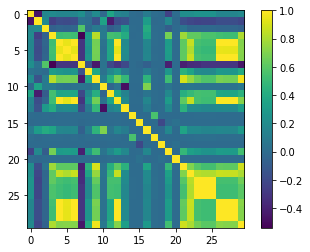

In [10]:
# Correlation analysis

correlation_matrix = np.corrcoef(x_train.T)

plt.imshow(correlation_matrix)
plt.colorbar()

In [11]:
def processing(x, deg, jet_mod=False, jet_num=0, mean=None, std=None):
    long_tails=[0, 1, 2, 3, 5, 8, 9, 10, 13, 16, 19, 21, 23, 26, 29]
    # Get the valid and invalid values (-999)
    missing_mask = x == -999
    correct_mask = x != -999
    
    # Log transform all the long tails
    for i in long_tails:
        # Only the valid values
        x[correct_mask[:,i],i] = np.log(1 + x[correct_mask[:,i],i])

    # Difference between angles
    angle = [15, 18, 20]
    diff01 = np.abs(x[:,angle[0]] - x[:,angle[1]]).reshape((len(x), 1))
    diff02 = np.abs(x[:,angle[0]] - x[:,angle[2]]).reshape((len(x), 1))
    diff12 = np.abs(x[:,angle[1]] - x[:,angle[2]]).reshape((len(x), 1))
    
    x = np.hstack((x, diff01, diff02, diff12))
            
    # Exclude some invalid variables depending of the jet_num
    if jet_mod:
        features_excluded = [[4, 5, 6, 12, 22, 23, 24, 25, 26, 27, 28], [4, 5, 6, 12, 22, 26, 27, 28], []]
        excepted = np.setdiff1d(np.arange(x.shape[1]), features_excluded[jet_num])
        x = x[:,excepted]
    print("Remaining number of variables: " + str(len(x[0])))
    
    # Cross terms
    indices_i = np.array(np.sum([[i for j in range(i)] for i in range(x.shape[1])]))
    indices_j = np.array(np.sum([[j for j in range(i)] for i in range(x.shape[1])]))
    cross_terms = x[:,indices_i] * x[:,indices_j]
    x = np.hstack((x, cross_terms))

    # Standardize
    x, mean, std = standardize(x, mean, std)

    # Build polynomial features
    x = build_poly(x, deg)
    
    # Add a bias term
    x = np.c_[np.ones(len(x)), x]
    
    return x, mean, std

def show_x(x):
    for i in range(len(x[0])):
        array = x[:,i]
        plt.hist(array, 250)
        plt.title("Variable %i: %s"%(i, headers[i+2]))
        plt.show()
    return x

In [12]:
# Load dataset
reload_dataset()

# Parameters
ratio = 0.8
deg = 1
accuracies = []
numbers = []

# We train a classifier for each "jet"
for i in range(3):
    print("Jet: " + str(i))
    # Select the corresponding rows
    jet_mask_train = x_train[:,22] == i
    jet_mask_test = x_test[:,22] == i
    if i == 2:
        # 2 and 3 are treated the same way
        jet_mask_train = np.asarray(x_train[:,22]==i) + np.asarray(x_train[:,22]==3) 
        jet_mask_test = np.asarray(x_test[:,22]==i) + np.asarray(x_test[:,22]==3) 
    x_jet_train, x_jet_test = x_train[jet_mask_train], x_test[jet_mask_test]
    y_jet_train, y_jet_test = y_train[jet_mask_train], y_test[jet_mask_test]

    # Process features
    x_jet_train, mean, std = processing(x_jet_train, deg, True, i)
    #x_jet_test, _, _ = processing(x_jet_test, deg, True, i, mean, std)

    # Split data (create a validation set)
    x_jet_train, y_jet_train, x_jet_valid, y_jet_valid = split_data(x_jet_train, y_jet_train, ratio)

    # Training
    #w, loss = least_squares_SGD(y_train2, train_processed_poly, np.zeros(train_processed_poly.shape[1]), 200, 3e-2)
    w, loss = ridge_regression(y_jet_train,x_jet_train, 1e-6)
    #w, loss = reg_logistic_regression_SGD((y_train2 == 1).astype(float), train_processed_poly, 1e-5,
    #	np.zeros(train_processed_poly.shape[1]), 2000, 1e-7)
    print("Loss = %f"%(loss))

    # Prediction
    y_jet_valid_pred = predict_labels(w, x_jet_valid)
    #y_jet_test_pred = predict_labels(w, x_jet_test)

    # Evaluation
    #create_csv_submission(ids_test[jet_mask_test], y_jet_test_pred, "submission" + str(i))
    accuracies.append(accuracy(y_jet_valid, y_jet_valid_pred))
    numbers.append(len(y_jet_valid))

print('\nGlobal accuracy:', np.dot(accuracies, numbers) / np.sum(numbers))

Jet: 0
Remaining number of variables: 22
Loss = 0.236142
Good prediction: 16671/19983 (83.426%)
Wrong prediction: 3312/19983 (16.574%)
Jet: 1
Remaining number of variables: 25
Loss = 0.328547
Good prediction: 11869/15509 (76.530%)
Wrong prediction: 3640/15509 (23.470%)
Jet: 2
Remaining number of variables: 33
Loss = 0.290482
Good prediction: 11686/14509 (80.543%)
Wrong prediction: 2823/14509 (19.457%)

Global accuracy: 0.804503909922
